## Extract Balanced Flows and Interpolate the gap between the two SWOT swaths using the KaRIn and Nadir data

In [1]:
import netCDF4 as nc
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist 
import mpmath as mp
import cartopy.crs as ccrs
from math import sin, cos, sqrt, atan2, radians
import os
import cmocean 
from glob import glob
import numpy as np
import time
import mpmath as mp
from scipy.special import gamma
import JWS_SWOT_toolbox as swot

%load_ext autoreload
%autoreload 2

### 1. Import the KaRIn and Nadir data, match the data files, and build the datasets 

Search through the data directory and import files for KaRIn and Nadir with same cycles and specified pass number

In [2]:
# Config. parameters
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/' # I'd recommend seperate the SCIENCE and CALVAL data

pass_number = 9
lat_min = 28 #32 #29
lat_max = 35 #38 #35

# return the files in the data directory for the specified pass number
# karin_files, nadir_files are sorted by cycle and contain the same cycles
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_number)

# Returns indexes for the Karin and Nadir data between lat_min and lat_max 
sample_index = 2 # some file we use to build the arrays in case the first one hsa NaNs
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims = [len(shared_cycles), track_length, track_length_nadir]
print(dims)

[95, 395, 115]


In [3]:
# Init the data classes -- (time, along_track, across_track)
karin, nadir = swot.init_swot_arrays(dims, lat_min, lat_max, pass_number)

# Load and process Karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

# Load and process Nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# Builds the coordinate grids -- in [m]
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

KaRIn Cycle 496 dropped: >20% bad-quality points
KaRIn Cycle 497 dropped: >20% bad-quality points


/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/import_and_process.py:230: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.017327167681867872
File indices with outlier variance: []
----------------------------------
Total Number of Good KaRIn strips : 186
Number of Quality Masked KaRIn strips : 127
Number of High Variance strips removed : 0

Number of good nadir cycles: 95
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


2023-05-10T22:42:41.652220000
517


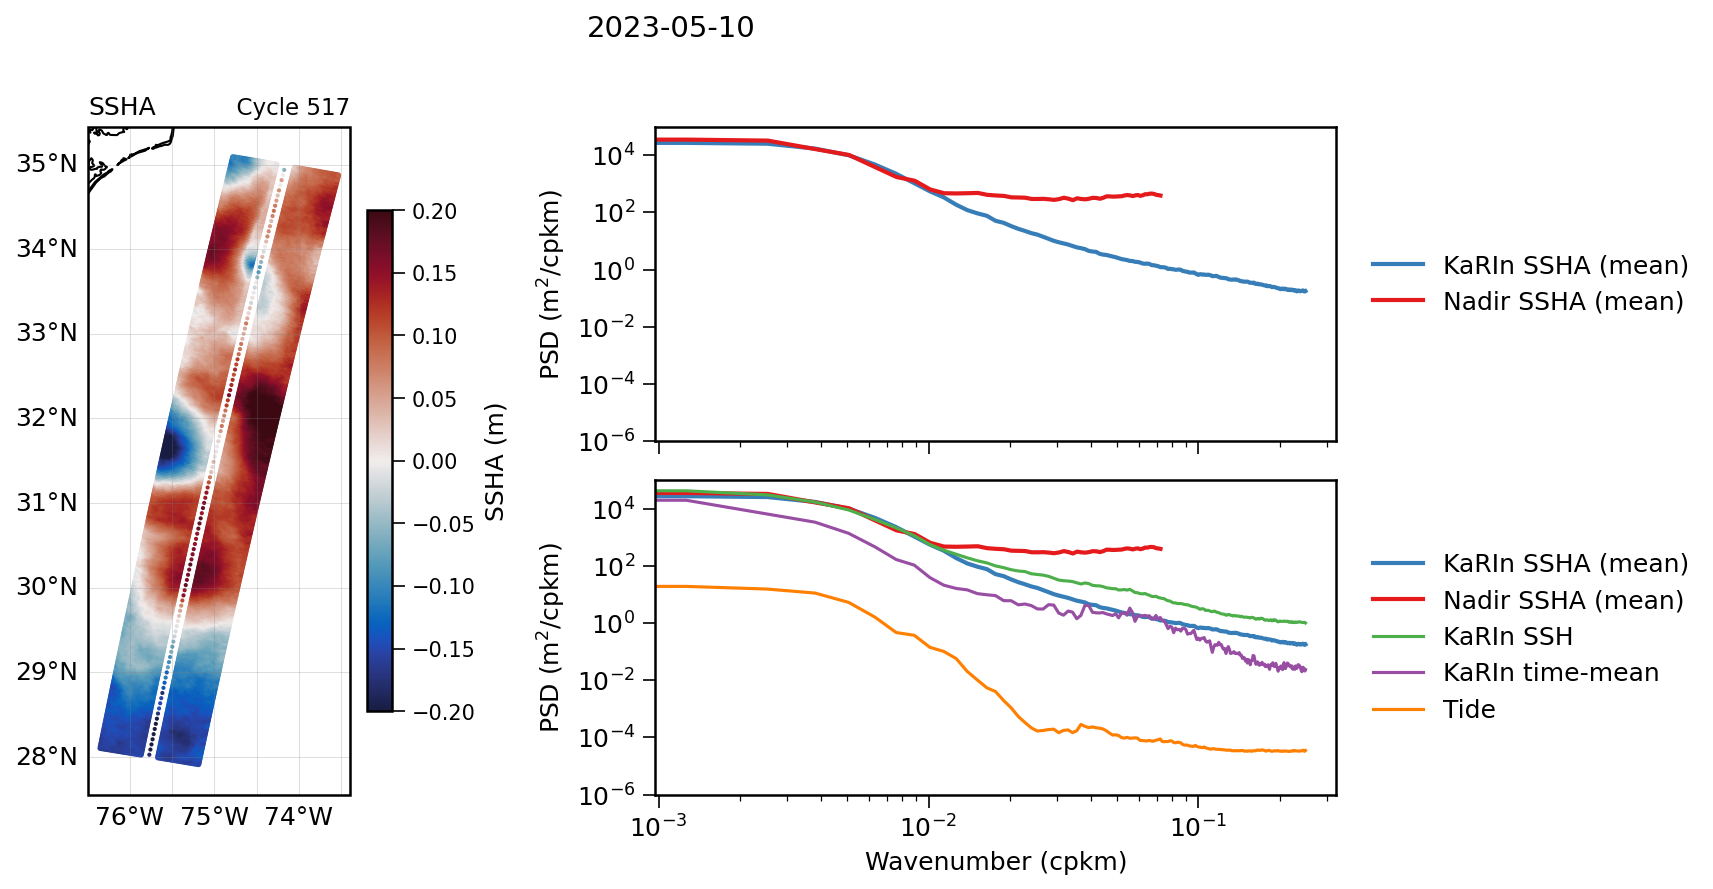

In [4]:
# --- Plot fields and spectra (fixed layout & axes) ---
index = 40
vmax = 0.2
vmin = -0.2
ylims = (1e-6, 1e5)

swot.set_plot_style()

# Use a single GridSpec for the whole figure
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(14, 6), dpi=150)
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1.25, 1.0], height_ratios=[1.0, 1.0], figure=fig)

# -------- Map (left column spans both rows) --------
ax1 = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
cmap = cmocean.cm.balance

sc = ax1.scatter(
    karin.lon[index, :, :], karin.lat[index, :, :],
    c=karin.ssha[index, :, :], s=3, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index, :], nadir.lat[index, :],
    c=nadir.ssh[index, :].flatten(), vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25, color='gray', linestyle='-',
                   xlabel_style={'size': 12}, ylabel_style={'size': 12})
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True
ax1.set_title('SSHA', loc='left')
ax1.set_title(f'\n  Cycle {shared_cycles[index]}', loc='right', fontsize=11)
cbar = fig.colorbar(sc, ax=ax1, orientation='vertical', shrink=0.75, pad=0.02)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('SSHA (m)')

# -------- Power Spectra (right column: two stacked panels) --------
# Consistent x in cycles per km
kx_karin = karin.wavenumbers_cpkm   # cycles/km
kx_nadir = nadir.wavenumbers_cpkm   # cycles/km

# Top spectra: along-track anomalies averaged over time/samples
ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(kx_karin, karin.spec_alongtrack_av, label='KaRIn SSHA (mean)', linewidth=2)
ax2.loglog(kx_nadir, nadir.spec_alongtrack_av, label='Nadir SSHA (mean)', linewidth=2)
ax2.set_ylabel('PSD (m$^2$/cpkm)')
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
ax2.tick_params(axis='x', which='both', labelbottom=False)

# Bottom spectra: components (SSH, time-mean, filtered, tide) + references
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)

# Guard against NaNs in optional components
def _safe_loglog(ax, x, y, *args, **kwargs):
    if y is None: 
        return
    y_plot = np.asarray(y)
    if y_plot.ndim == 0: 
        return
    ax.loglog(x, y_plot, *args, **kwargs)

# KaRIn components
_safe_loglog(ax3, kx_karin, karin.spec_alongtrack_av, label='KaRIn SSHA (mean)', linewidth=2)
_safe_loglog(ax3, kx_nadir, nadir.spec_alongtrack_av, label='Nadir SSHA (mean)', linewidth=2)
_safe_loglog(ax3, kx_karin, karin.spec_ssh,           label='KaRIn SSH', linewidth=1.5)
_safe_loglog(ax3, kx_karin, karin.spec_tmean,         label='KaRIn time-mean', linewidth=1.5)
_safe_loglog(ax3, kx_karin, karin.spec_filt_tmean,    label='KaRIn time-mean (filtered)', linewidth=1.5)
_safe_loglog(ax3, kx_karin, karin.spec_tide,          label='Tide', linewidth=1.5)

ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('PSD (m$^2$/cpkm)')
ax3.set_ylim(ylims)
ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plot_dt = karin.time_dt[index]  # or nadir.time_cycle_dt[index]
print(plot_dt)
print(shared_cycles[index])
if not np.isnat(plot_dt):
    fig.suptitle(str(plot_dt)[:10], fontsize=14, y=0.98)

plt.tight_layout()
plt.show()

## 2. Extract the balanced signal

### Model balanced and unbalanced signal from KaRIn and nadir


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.6756e+04 ± 2.39e+02
lambda balanced :   2.2340e+02 ± 1.39e+00
slope balanced  :   4.7161e+00 ± 5.09e-02
Amp. noise      :   4.3583e+01 ± 3.48e+01
lambda noise    :   1.0001e+02 ± 4.83e+01
slope noise     :   1.7609e+00 ± 2.28e-02

---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 326.15501142043803 ± 1.46e+01


(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

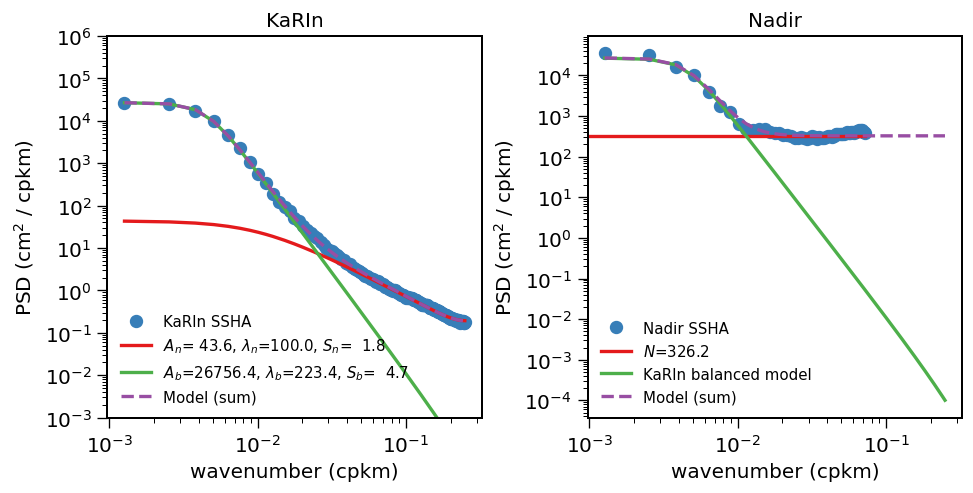

In [5]:
# KaRIn model fit
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir)

## 3. Generate Covariances 

We now generate covariance functions for our spectrum models to extract the balanced component and also interpolate the gap. 

First we will do a test reconstruction with a random signal and noise field which will have the same spectral characteristics as the SWOT spectra above.

Our target grid we extend from 60 pixels to 64 using the GPR to get input suitable for ST. 

In [6]:
index = 6 # time index to estimate on 
print(shared_cycles[index])

nx, ny, nn = 2 * karin.swath_width, karin.track_length, nadir.track_length
dx, dy, dn = karin.dx_km, karin.dy_km, nadir.dy_km

# Create covariance functions
c = swot.balanced_covariance_func(poptcwg_karin)
nk = swot.noise_covariance_func(poptcwg_karin)

N_n = poptcwg_nadir[0] # Nadir noise
sigma = np.sqrt(N_n / (2 * dn))

# Observation points
xk, yk = swot.make_karin_points(karin, 'km') # builds the grids in km since we fit spectra in cpkm
xn, yn = swot.make_nadir_points(karin, nadir, 'km')

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# Covariance matrices
C = swot.build_covariance_matrix(c, xobs, yobs)
N, Nk = swot.build_noise_matrix(nk, xk, yk, sigma, nn, nx * ny)

# Cholesky decompositions
F = swot.cholesky_decomp(C, "C")
Fk = swot.cholesky_decomp(Nk, "Nk")

483
Δk (spacing): 0.000100 cpkm
k_max (maximum wavenumber): 250.000000 cpkm
Variance from spectrum:   129.085489
Variance from covariance: 129.085489
Δk (spacing): 0.000100 cpkm
k_max (maximum wavenumber): 0.250000 cpkm
Variance from spectrum:   0.769978
Variance from covariance: 0.769978
Calculating covariance matrices...
Calculating noise matrices...
Performing Cholesky decomposition for C...
Cholesky(C) time: 97.8304 seconds
Performing Cholesky decomposition for Nk...
Cholesky(Nk) time: 78.7967 seconds


## 5. Apply the models to the real SWOT SSH data 

In [7]:
import numpy as np
from scipy.linalg import block_diag
import scipy.linalg as la

# --- Masks (index into arrays) ---
mask_k = np.isfinite(karin.ssha[index])
mask_n = np.isfinite(nadir.ssh[index]).ravel()

# --- KaRIn (2D) ---
hkk = karin.ssha[index][mask_k].ravel()
xkk_km = (karin.x_grid[mask_k].ravel()) * 1e-3  # km
ykk_km = (karin.y_grid[mask_k].ravel()) * 1e-3  # km

# --- Nadir (1D) ---
hn  = np.ravel(nadir.ssh[index])
xn  = np.ravel(nadir.x_grid)
yn  = np.ravel(nadir.y_grid)

hnn = hn[mask_n]
xnn_km = (xn[mask_n]) * 1e-3                    # km
ynn_km = (yn[mask_n]) * 1e-3                    # km

# --- Concatenate obs + coords (all in km) ---
h_obs = np.concatenate([hkk, hnn])
xobs_km = np.concatenate([xkk_km, xnn_km])
yobs_km = np.concatenate([ykk_km, ynn_km])

# --- Signal covariance (all obs) ---
C_obs = swot.build_covariance_matrix(c, xobs_km, yobs_km)  # c must expect km

# --- Noise: KaRIn correlated + Nadir white ---
# KaRIn block (pairwise distances in km)
dxk = xkk_km[:, None] - xkk_km[None, :]
dyk = ykk_km[:, None] - ykk_km[None, :]
Nk_obs = nk(np.hypot(dxk, dyk))  # nk(r_km) expects km

# Nadir block (white noise variance per sample)
Nn_obs = (sigma**2) * np.eye(len(xnn_km))  # sigma is in data units, not affected by coord units

N_obs = block_diag(Nk_obs, Nn_obs)

# --- Target grid + estimate (also in km) ---
xt_km, yt_km, nxt, nyt, _, _ = swot.make_target_grid(karin, unit='km', extend=False)

# compute the covariance first 
R = c(np.hypot(xt_km[:, None] - xobs_km, yt_km[:, None] - yobs_km))

#build cholesky factor
cho_tuple = la.cho_factor(C_obs + N_obs, lower=True)

# Estimate signal
ht = swot.estimate_signal_on_target_cho_solve(R, cho_tuple, h_obs) # faster function

Calculating covariance matrices...
Signal estimation time: 1.5315 seconds


790.4518807485474
120.036783769289


/scratch/jskinner1/job_44007735/ipykernel_1073771/1645496436.py:115: UserWarning: The following kwargs were not used by contour: 'rasterized'
  cf0 = axes[1].contourf(XX, YY, ht_map, levels=ssh_levels,  origin="upper", cmap='cmo.balance', extend='both',rasterized=True)
/scratch/jskinner1/job_44007735/ipykernel_1073771/1645496436.py:123: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for ca in cf0.collections:
/scratch/jskinner1/job_44007735/ipykernel_1073771/1645496436.py:127: UserWarning: The following kwargs were not used by contour: 'rasterized'
  cf1 = axes[2].contourf(XX, YY, geo_vel, levels=grad_levels,  origin="upper",cmap='cmo.deep_r', extend='both', rasterized=True)
/scratch/jskinner1/job_44007735/ipykernel_1073771/1645496436.py:135: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for ca in cf1.collec

Balanced_SSH: max=0.3057, min=-0.2485, std=0.09909
Geostrophic_Speed: max=2, min=0.004024, std=0.292
Vorticity: max=3.064, min=-1.288, std=0.4631


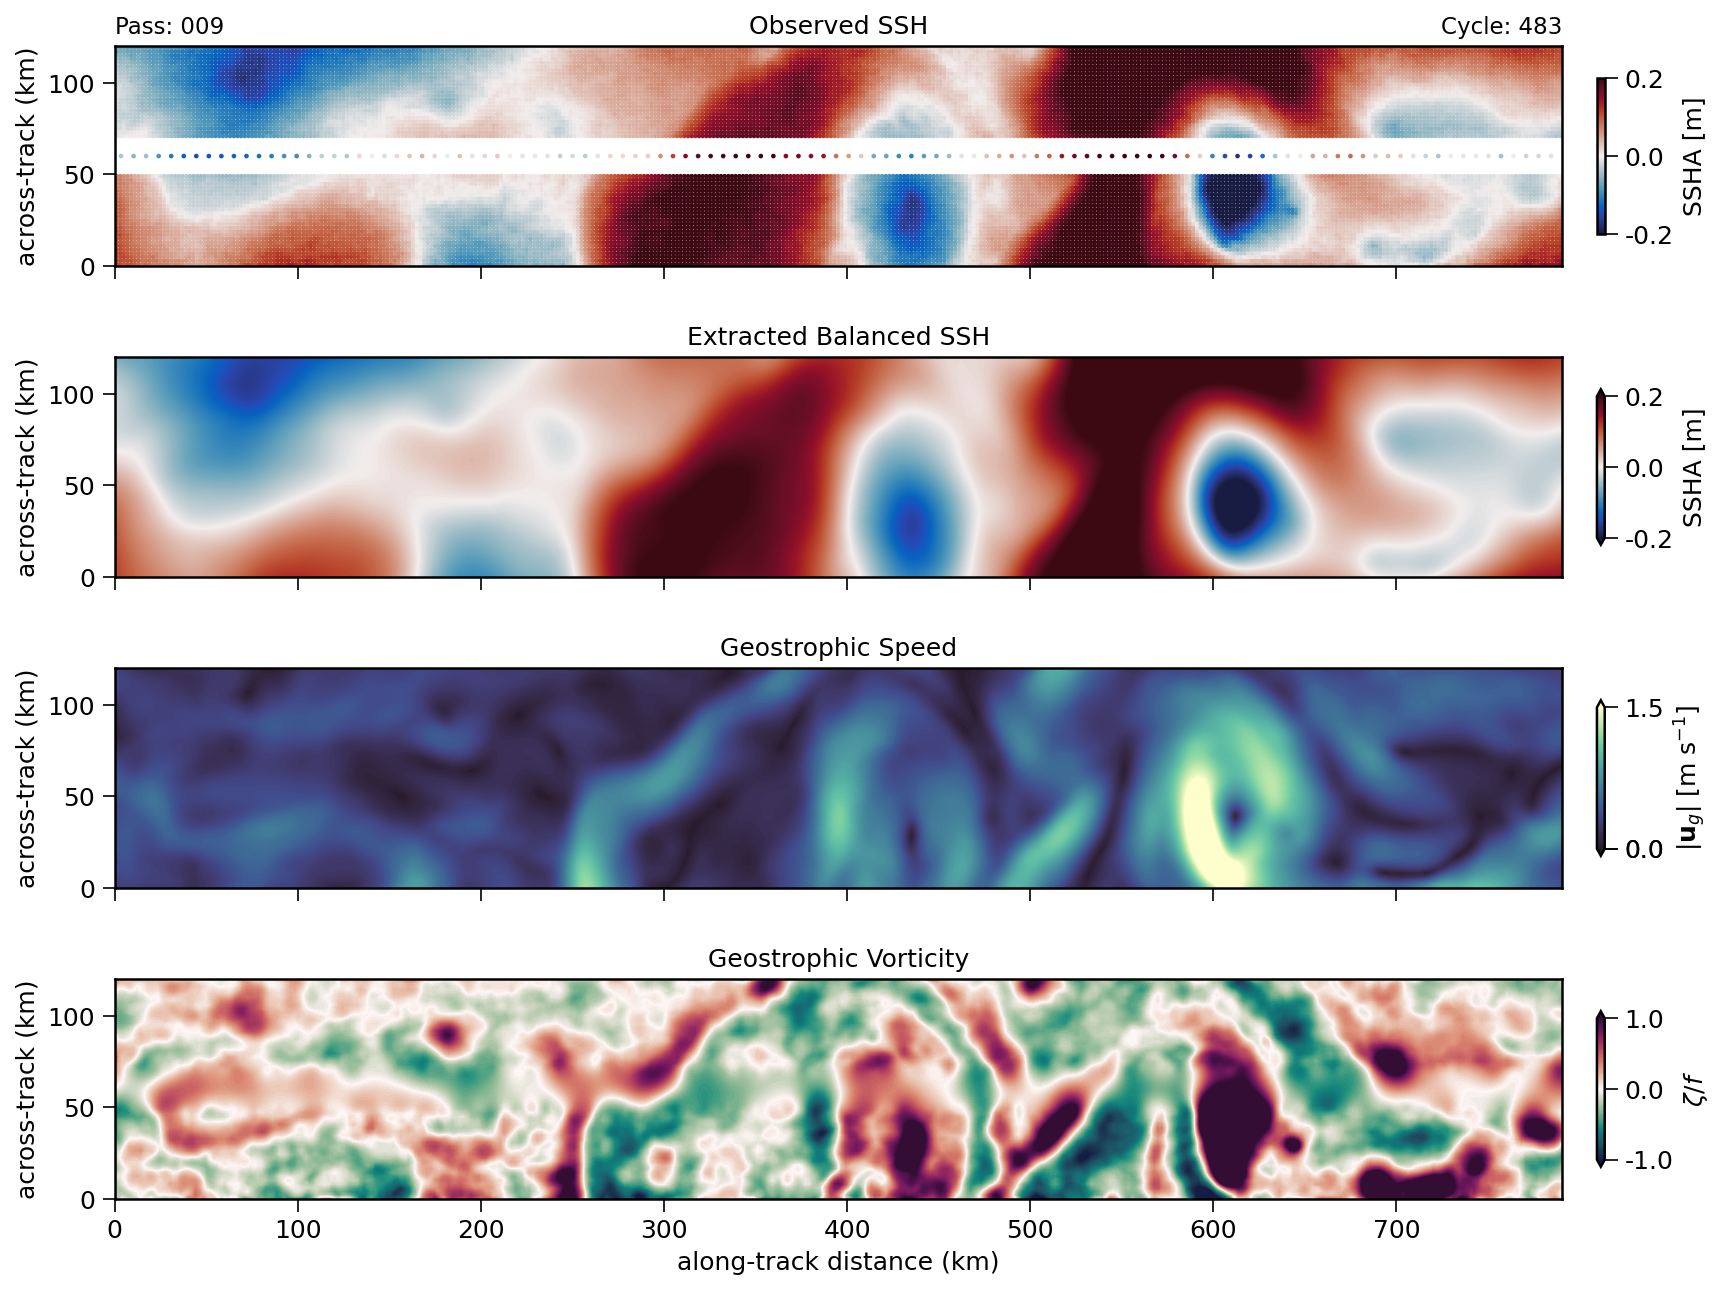

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import importlib
importlib.reload(swot)
from scipy.ndimage import gaussian_filter

# --- Pixel sizes (km) ---
dx_km = float(karin.dy) * 1e-3   # along-track spacing (km) used for columns (X)
dy_km = float(karin.dx) * 1e-3   # across-track spacing (km) used for rows (Y)
# If your orientation is swapped, swap the two lines above.

# Half-pixel target distance r (km). If your pixel is 2 km, r = 1 km.
d_km = min(dx_km, dy_km)         # pixel size (km)
r_km = d_km / 2.0                # half a pixel

# Sigma so that autocorr at r_km equals 0.5
sigma_km = r_km / (2.0 * np.sqrt(np.log(2.0)))

# Convert to pixels for each axis
sigma_pix_x = sigma_km / dx_km
sigma_pix_y = sigma_km / dy_km

# ── reshape the map and pick colour limits 
ht_map = ht.reshape(nyt, nxt).T  # shape: (nxt, nyt) -> [y,x]
vmin, vmax = -0.20, 0.20

# Axes coordinates in km (x = along-track, y = across-track)
x_km = np.linspace(0, nyt * karin.dx * 1e-3, ht_map.shape[1])  # columns
y_km = np.linspace(0, nxt * karin.dy * 1e-3, ht_map.shape[0])  # rows
XX, YY = np.meshgrid(x_km, y_km)

print(np.max(x_km))
print(np.max(y_km))

# ── figure with adjusted size for equal aspect
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True,
                         gridspec_kw={"hspace": 0.4})

# Get the original data for scatter plot - don't use the processed versions
karin_data = karin.ssha[index]
nadir_data = nadir.ssh[index]

# Create coordinate meshgrids if needed
if len(karin.x_grid.shape) == 1:
    x_grid_k, y_grid_k = np.meshgrid(karin.x_grid, karin.y_grid)
else:
    x_grid_k = karin.x_grid
    y_grid_k = karin.y_grid

# Apply masks and get valid data
mask_k_2d = np.isfinite(karin_data)
mask_n_1d = np.isfinite(nadir_data)

# KaRIn scatter
x_k_valid = x_grid_k[mask_k_2d].flatten()
y_k_valid = y_grid_k[mask_k_2d].flatten()
ssh_k_valid = karin_data[mask_k_2d].flatten()

# Nadir scatter
if len(nadir.x_grid.shape) == 1:
    x_n_valid = nadir.x_grid[mask_n_1d]
    y_n_valid = nadir.y_grid[mask_n_1d]
else:
    x_n_valid = nadir.x_grid.flatten()[mask_n_1d.flatten()]
    y_n_valid = nadir.y_grid.flatten()[mask_n_1d.flatten()]
ssh_n_valid = nadir_data[mask_n_1d]

# ── Panel 0: Observed SSH (scatter)
sc1 = axes[0].scatter(
    y_k_valid * 1e-3, x_k_valid * 1e-3,  # across (y) vs along (x)
    c=ssh_k_valid, s=5, cmap='cmo.balance',
    vmin=vmin, vmax=vmax, edgecolor="none", 
    rasterized=True
)
# overlay nadir with same scale
axes[0].scatter(
    y_n_valid * 1e-3, x_n_valid * 1e-3,
    c=ssh_n_valid, s=5, cmap='cmo.balance',
    vmin=vmin, vmax=vmax, edgecolor="none", 
    rasterized=True
)
axes[0].set_title("Observed SSH")
axes[0].set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
axes[0].set_title(f"Pass: {pass_number:03d}", fontsize=11, loc='left')
axes[0].set_ylabel("across-track (km)")
axes[0].margins(x=0, y=0) 
axes[0].set_ylim(0, y_km.max())   # if across-track is on y
axes[0].set_xlim(0, x_km.max())   # and along-track on x
axes[0].set_aspect("equal")  # Equal aspect ratio
cbar0 = fig.colorbar(sc1, ax=axes[0], orientation='vertical', shrink=0.7, pad=0.02)
cbar0.set_ticks([vmin, 0, vmax])
cbar0.set_ticklabels([f'{vmin:.1f}', '0.0', f'{vmax:.1f}'])
cbar0.set_label(r'SSHA [m]')

# ── Diagnostics
lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), ht_map.shape[0])
geo_vort = swot.compute_geostrophic_vorticity(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
#grad_mag = swot.compute_gradient_magnitude(ht_map)
_, _, geo_vel = swot.compute_geostrophic_velocity(np.ma.masked_invalid(ht_map), 2000, 2000, lats)

# Ensure each panel's color scale includes 0 so the middle tick is meaningful
ssh_levels  = np.linspace(vmin, vmax, 400)

# Gradient: force vmin to include 0 for the 0-tick
grad_vmin = 0 #min(0.0, grad_data_min)
grad_vmax = 1.5 #0.9* grad_data_max
grad_levels = np.linspace(grad_vmin, grad_vmax, 100)

# Vorticity: choose symmetric limits around 0 (you had these already)
vort_vmin, vort_vmax = -1.0, 1.0
vort_levels = np.linspace(vort_vmin, vort_vmax, 100)

# ── Panel 1: Extracted Balanced SSH (contourf)
cf0 = axes[1].contourf(XX, YY, ht_map, levels=ssh_levels,  origin="upper", cmap='cmo.balance', extend='both',rasterized=True)
axes[1].set_title("Extracted Balanced SSH")
axes[1].set_ylabel("across-track (km)")
axes[1].set_aspect("equal")
cbar1 = fig.colorbar(cf0, ax=axes[1], orientation='vertical', shrink=0.7, pad=0.02)
cbar1.set_ticks([vmin, 0, vmax])
cbar1.set_ticklabels([f'{vmin:.1f}', '0.0', f'{vmax:.1f}'])
cbar1.set_label(r'SSHA [m]')
for ca in cf0.collections:
    ca.set_rasterized(True)

# ── Panel 2: Gradient magnitude (contourf) — three ticks: min, 0, max
cf1 = axes[2].contourf(XX, YY, geo_vel, levels=grad_levels,  origin="upper",cmap='cmo.deep_r', extend='both', rasterized=True)
axes[2].set_title(r"Geostrophic Speed")
axes[2].set_ylabel("across-track (km)")
axes[2].set_aspect("equal")
cbar2 = fig.colorbar(cf1, ax=axes[2], orientation='vertical', shrink=0.7, pad=0.02)
cbar2.set_ticks([grad_vmin, 0, grad_vmax])
cbar2.set_ticklabels([f'{grad_vmin:.1f}', '0.0', f'{grad_vmax:.1f}'])
cbar2.set_label(r'$|\mathbf{u}_g|$ [m s$^{-1}$]')
for ca in cf1.collections:
    ca.set_rasterized(True)

# ── Panel 3: Geostrophic Vorticity (contourf) — three ticks: min, 0, max
cf2 = axes[3].contourf(XX, YY, geo_vort, levels=vort_levels, origin="upper",cmap='cmo.curl', extend='both',  rasterized=True)
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
axes[3].set_aspect("equal")
cbar3 = fig.colorbar(cf2, ax=axes[3], orientation='vertical', shrink=0.7, pad=0.02)
cbar3.set_ticks([vort_vmin, 0, vort_vmax])
cbar3.set_ticklabels([f'{vort_vmin:.1f}', '0.0', f'{vort_vmax:.1f}'])
cbar3.set_label(r'$\zeta / f$')
for ca in cf2.collections:
    ca.set_rasterized(True)

fields = {"Balanced_SSH": ht_map, "Geostrophic_Speed": geo_vel, "Vorticity": geo_vort}
print("\n".join(f"{k}: max={np.nanmax(v):.4g}, min={np.nanmin(v):.4g}, std={np.nanstd(v):.4g}" for k,v in fields.items()))

#plt.tight_layout()
plt.savefig("balanced_extraction.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Posterior covariance, this takes some time 
import numpy as np
from scipy.linalg import solve

C_target = swot.build_covariance_matrix(c, xt_km, yt_km) # Covariance of my target matrix

#  P = C_target - R(C_obs + N_obs)⁻¹ @ R.T
print("Solving linear part")
term = la.cho_solve(cho_tuple, R.T)

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_field = posterior_variance.reshape(nyt, nxt)
print("Done.")

Calculating covariance matrices...
Solving linear part


In [11]:
# === 2. Posterior covariance (Eq. 10) ===
print("Cholesky decomposition of posterior covariance P...")
L = np.linalg.cholesky(P)

# --- Also compute covariance of the posterior mean (Eq. 9 second term) ---
print("Computing covariance of posterior mean (C_mean = R(C+N)^-1 R^T)...")
C_mean = R @ term  # equivalent to C_target - P

print("done")

Cholesky decomposition of posterior covariance P...
Computing covariance of posterior mean (C_mean = R(C+N)^-1 R^T)...
done


In [12]:
# === 1. Spectrum of the mean estimate from balanced extraction ===
ht_NA_2d = ht.reshape(nyt, nxt).T
ht_NA_coords = { 
    'pixel': np.arange(0.5, np.shape(ht_NA_2d)[0], 1.0) * karin.dy_km, 
    'line': np.arange(0.5, np.shape(ht_NA_2d)[1], 1.0) * karin.dx_km
}
ht_map_xr = xr.DataArray(ht_NA_2d, coords=ht_NA_coords, dims=['pixel', 'line'])
window_line = xr.DataArray(swot.sin2_window_func(np.shape(ht_NA_2d)[1]),
                           dims=['line'], coords={'line': ht_map_xr['line']})
spec_ht_map = swot.mean_power_spectrum(ht_map_xr, window_line, 'line', ['pixel'])
bal_k = spec_ht_map.freq_line[int(karin.track_length/2):]
spec_ht_map = 2 * spec_ht_map[int(karin.track_length/2):]

# Cholesky for posterior-mean covariance
eps = 1e-10 * np.trace(C_mean) / C_mean.shape[0]
L_mean = np.linalg.cholesky(C_mean + eps * np.eye(C_mean.shape[0]))

nreal = 20
half_idx = int(karin.track_length // 2)
rng = np.random.default_rng(seed=42)

all_specs = []               # posterior spectra
all_specs_uncertainty = []   # uncertainty (P) spectra
all_specs_mean_cov = []      # covariance of posterior mean (C_mean) spectra

for i in range(nreal):
    # === Posterior covariance sampling (uncertainty realizations) ===
    z = rng.standard_normal(len(P))
    eps = L @ z
    sample = ht + eps  # posterior sample = mean + uncertainty

    field2d = sample.reshape((nyt, nxt), order='C')
    da = xr.DataArray(
        field2d[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )

    spec_xr = swot.mean_power_spectrum(da, karin.window, 'line', ['sample', 'pixel'])
    spec_vals = 2 * spec_xr[int(karin.track_length/2):]
    spec_1d = spec_vals[half_idx:] if spec_vals.size == karin.wavenumbers_cpkm.size else spec_vals
    all_specs.append(spec_1d)

    # === Posterior uncertainty spectrum (from eps field) ===
    field2d_unc = eps.reshape((nyt, nxt), order='C')
    da_unc = xr.DataArray(
        field2d_unc[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr_unc = swot.mean_power_spectrum(da_unc, karin.window, 'line', ['sample', 'pixel'])
    spec_vals_unc = 2 * spec_xr_unc[int(karin.track_length/2):]
    spec_1d_unc = spec_vals_unc[half_idx:] if spec_vals_unc.size == karin.wavenumbers_cpkm.size else spec_vals_unc
    all_specs_uncertainty.append(spec_1d_unc)

    # === Covariance of posterior mean sampling ===
    zm = rng.standard_normal(len(C_mean))
    eps_mean = L_mean @ zm
    field2d_mean = eps_mean.reshape((nyt, nxt), order='C')
    da_mean = xr.DataArray(
        field2d_mean[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr_mean = swot.mean_power_spectrum(da_mean, karin.window, 'line', ['sample', 'pixel'])
    spec_vals_mean = 2 * spec_xr_mean[int(karin.track_length/2):]
    spec_1d_mean = spec_vals_mean[half_idx:] if spec_vals_mean.size == karin.wavenumbers_cpkm.size else spec_vals_mean
    all_specs_mean_cov.append(spec_1d_mean)

# === 3. Aggregate stats ===
all_spectra = np.array(all_specs)
spec_mean = np.nanmean(all_spectra, axis=0)
spec_std = np.nanstd(all_spectra, axis=0)
spec_median = np.nanmedian(all_spectra, axis=0)
spec_mean_uncertainty = np.nanmean(np.array(all_specs_uncertainty), axis=0)
spec_mean_of_mean = np.nanmean(np.array(all_specs_mean_cov), axis=0)

print("Spectral diagnostics computed:")
print("  - spec_mean: posterior mean spectrum")
print("  - spec_mean_uncertainty: posterior uncertainty spectrum")
print("  - spec_mean_of_mean: covariance of posterior mean spectrum")

Spectral diagnostics computed:
  - spec_mean: posterior mean spectrum
  - spec_mean_uncertainty: posterior uncertainty spectrum
  - spec_mean_of_mean: covariance of posterior mean spectrum


In [15]:
# First, spectrum of the mean estimate from balanced extraction 
ht_NA_2d = ht.reshape(nyt, nxt).T
ht_NA_coords = { 
    'pixel': np.arange(0.5, np.shape(ht_NA_2d)[0], 1.0) * karin.dy_km, 
    'line': np.arange(0.5, np.shape(ht_NA_2d)[1], 1.0) * karin.dx_km
    }

ht_map_xr = xr.DataArray(ht_NA_2d, coords = ht_NA_coords, dims = ['pixel', 'line'])
window_line = xr.DataArray(swot.sin2_window_func(np.shape(ht_NA_2d)[1]), dims=['line'], coords={'line': ht_map_xr['line']})
spec_ht_map = swot.mean_power_spectrum(ht_map_xr, window_line, 'line', ['pixel'])
bal_k = spec_ht_map.freq_line[int(karin.track_length/2):] 
spec_ht_map = 2 *spec_ht_map[int(karin.track_length/2):]

L = np.linalg.cholesky(P)

nreal = 20
half_idx = int(karin.track_length // 2)
rng = np.random.default_rng(seed=42)

all_specs = [] # posterior spectra
all_specs_uncertainty = [] # uncertainties of the spectra 

for i in range(nreal):
    z = rng.standard_normal(len(P))
    eps = L @ z
    # posterior spectrum
    sample = ht + eps # we need to convert our fields back into cms since that's what the extraction is done in
    field2d = sample.reshape((nyt, nxt), order='C')
    da = xr.DataArray(
        (field2d)[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    
    spec_xr = swot.mean_power_spectrum(da, karin.window, 'line', ['sample', 'pixel'])
    spec_vals =  2 *spec_xr[int(karin.track_length/2):]
    
    if spec_vals.size == karin.wavenumbers_cpkm.size:
        spec_1d = spec_vals[half_idx:]
    else:
        spec_1d = spec_vals
    all_specs.append(spec_1d)
    
    # Spectrum of the posterior uncertainty
    field2d_unc = eps.reshape((nyt, nxt), order='C')
    da_unc = xr.DataArray(
        (field2d_unc)[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr_unc = swot.mean_power_spectrum(da_unc, karin.window, 'line', ['sample', 'pixel'])
    spec_vals_unc = 2 *spec_xr_unc[int(karin.track_length/2):]
    
    if spec_vals_unc.size == karin.wavenumbers_cpkm.size:
        spec_1d_unc = spec_vals_unc[half_idx:]
    else:
        spec_1d_unc = spec_vals_unc
    
    all_specs_uncertainty.append(spec_1d_unc)

all_spectra = np.array(all_specs)
spec_mean = np.nanmean(all_spectra, axis=0)
spec_std = np.nanstd(all_spectra, axis=0)
spec_median = np.nanmedian(all_spectra, axis=0)
spec_mean_uncertainty = np.nanmean(np.array(all_specs_uncertainty), axis=0)

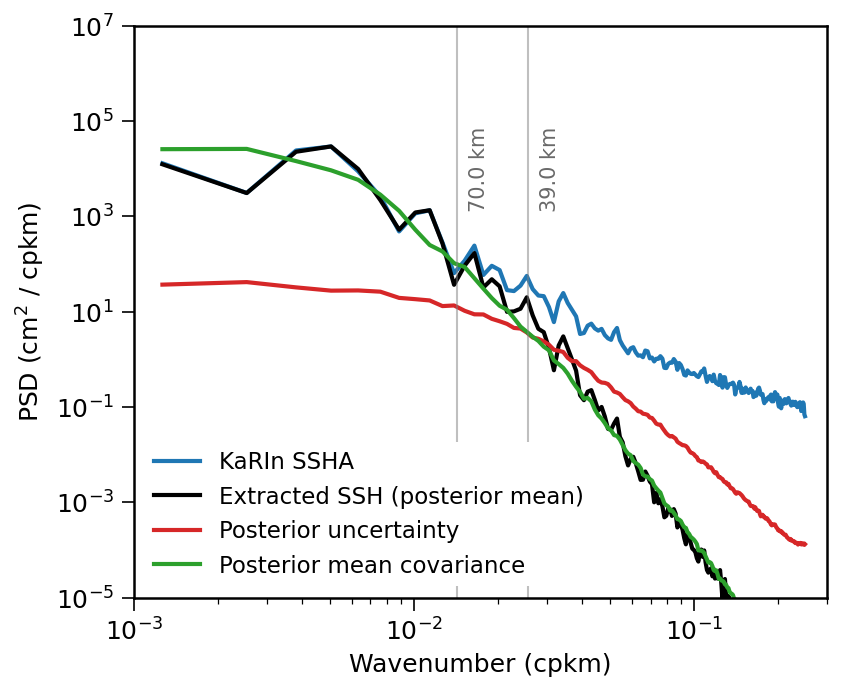

In [23]:
def plot_spectrum_comparison(karin_obj, swot_obj, poptcwg_karin_params, ht_map_2d):
    
    # Extract KaRIn wavenumbers and sample mean spectrum
    k_karin = karin_obj.wavenumbers_cpkm[int(karin_obj.track_length/2):]
    karin_spec_sample_mean = karin_obj.spec_alongtrack_av[int(karin_obj.track_length/2):]

    # Ensure consistent slicing for model inputs (skipping the first wavenumber)
    k_karin_sliced = k_karin[1:]

    # Put the wavenumbers through the models to get the functional form
    spbalanced = swot_obj.balanced_model_tapered(k_karin_sliced, *poptcwg_karin_params[0:3])
    spunbalanced = swot_obj.unbalanced_model_tapered(k_karin_sliced, *poptcwg_karin_params[3:7])

    nx_dim = ht_map_2d.shape[1] # Along-track dimension
    ny_dim = ht_map_2d.shape[0] # Across-track dimension 
    ht_map_coords = {
        'pixel': np.arange(0, ny_dim) * karin_obj.dy_km, # Across-track coordinate
        'line': np.arange(0, nx_dim) * karin_obj.dx_km   # Along-track coordinate
    }
    ht_map_xr = xr.DataArray((ht_map_2d - np.mean(ht_map_2d)) * 100, coords=ht_map_coords, dims=['pixel', 'line'])
    spec_ht_map_2s = swot_obj.mean_power_spectrum(ht_map_xr, karin_obj.window, 'line', ['pixel'])
    spec_ht_map = spec_ht_map_2s[int(karin_obj.track_length/2):][1:]

    # KaRIn instantaneous spectrum
    spec_k_ins = karin.spec_alongtrack_ins[index][int(karin_obj.track_length/2):][1:]


    # --- Plotting ---
    fig, axs = plt.subplots(1, 1, figsize=(5.5, 4.5), dpi=150, constrained_layout=True)
    k_km = k_karin_sliced 
    
    # axs.loglog(
    #     k_km, karin_spec_sample_mean[1:], 'o', color='blue',
    #     label='KaRIn SSHA Time Av.'
    # )

    axs.loglog(
        k_km, spec_k_ins, color='tab:blue',
        label='KaRIn SSHA'
    )
    
    # Unbalanced (tab:orange)
    # axs.loglog(
    #     k_km, spunbalanced , color='tab:orange',
    #     label=r'Noise model'
    # )
    
    # Balanced (tab:green)
    # axs.loglog(
    #     k_km, spbalanced , color='tab:green',
    #     label=r'Balanced Model'
    # )
    
    # Extracted balanced flow (tab:red, solid)
    axs.loglog(
        k_km, spec_ht_map , '-', lw=2, color='black',
        label='Extracted SSH (posterior mean)'
    )

    axs.loglog(k_km[:], 0.5*spec_mean_uncertainty[1:], color='tab:red', label = 'Posterior uncertainty')
    axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:],color='tab:green', label = 'Posterior mean covariance')
    #axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:] + 0.5*spec_mean_uncertainty[1:],color='tab:purple', label = 'Sum')

    separation_scale_km = 39
    separation_wavenumber = 1/separation_scale_km 
    axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    text_label = f'{separation_scale_km:.1f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label,
            rotation=90,          # Rotate text to be vertical
            color='dimgrey',      # A slightly darker grey for readability
            fontsize=10,
            verticalalignment='center',
            horizontalalignment='left')

    separation_scale_km = 70
    separation_wavenumber = 1/separation_scale_km 
    axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    text_label = f'{separation_scale_km:.1f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label,
            rotation=90,          # Rotate text to be vertical
            color='dimgrey',      # A slightly darker grey for readability
            fontsize=10,
            verticalalignment='center',
            horizontalalignment='left')
    
    # Axis labels and limits
    axs.set_xlabel('Wavenumber (cpkm)')
    axs.set_ylabel('PSD (cm$^2$ / cpkm)')
    axs.set_xlim(1e-3, 3e-1)
    axs.set_ylim(1e-5, 1e7)
    #axs.set_title('Extracted Balanced Power Spectrum')
    
    # Legend (will follow plotting order above)
    axs.legend(
        loc='lower left',
        frameon=True,
        facecolor='white',
        edgecolor='none',
        framealpha=1.0,
        fontsize=11
    )
    
    plt.savefig('balanced_spectrum.pdf', bbox_inches='tight')
    plt.show()

ht_map = ht.reshape(nyt, nxt).T  # shape: (nxt, nyt) -> [y,x]
plot_spectrum_comparison(
        karin_obj=karin,
        swot_obj=swot,
        poptcwg_karin_params=poptcwg_karin,
        ht_map_2d=ht_map
    )

## Compute the posterior covariances and standard deviations

In [ ]:
### Compute the posterior variances
from scipy.linalg import cho_factor, cho_solve, cholesky
import scipy.sparse as sp
    
# compute the covariance first 
R = c(np.hypot(xt_km[:, None] - xobs_km, yt_km[:, None] - yobs_km))
C_target = swot.build_covariance_matrix(c, xt_km, yt_km) # Covariance of my target matrix

#  P = C_target - R(C_obs + N_obs)⁻¹ @ R.T
print("Solving linear part")
#term = solve(C_obs + N_obs, R.T, assume_a='pos') # assume positive definite 
CF = cho_factor(C_obs + N_obs, lower=False, check_finite=False)
term = cho_solve(CF, R.T, check_finite=False)

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_field = posterior_variance.reshape(nyt, nxt)
print("Done.")

In [14]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import cholesky

def laplacian_operator(ny, nx, dx, dy):
    N = ny * nx
    L = sp.lil_matrix((N, N))
    dx2 = dx**2
    dy2 = dy**2

    for j in range(ny):
        for i in range(nx):
            k = j * nx + i
            
            # Interior points (standard 5-point stencil)
            if 1 <= i < nx-1 and 1 <= j < ny-1:
                L[k, k-1] = 1.0/dx2
                L[k, k+1] = 1.0/dx2
                L[k, k-nx] = 1.0/dy2
                L[k, k+nx] = 1.0/dy2
                L[k, k] = -2.0/dx2 - 2.0/dy2

            # Boundaries with second-order accurate stencils
            else:
                # Handle x-direction
                if i == 0:
                    L[k, k] += -2.0/dx2
                    L[k, k+1] = 2.0/dx2
                elif i == nx-1:
                    L[k, k] += -2.0/dx2
                    L[k, k-1] = 2.0/dx2
                else:
                    L[k, k-1] = 1.0/dx2
                    L[k, k+1] = 1.0/dx2
                    L[k, k] += -2.0/dx2

                # Handle y-direction
                if j == 0:
                    L[k, k] += -2.0/dy2
                    L[k, k+nx] = 2.0/dy2
                elif j == ny-1:
                    L[k, k] += -2.0/dy2
                    L[k, k-nx] = 2.0/dy2
                else:
                    L[k, k-nx] = 1.0/dy2
                    L[k, k+nx] = 1.0/dy2
                    L[k, k] += -2.0/dy2

    return L.tocsr()

def gradient_operator(ny, nx, dx, dy):

    N = ny * nx
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))
    
    def idx(i, j): 
        return j * nx + i
    
    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)
            
            # X-derivative
            if i == 0:
                # Forward difference (first order for stability)
                Gx[k, idx(0, j)] = -1.0 / dx
                Gx[k, idx(1, j)] = 1.0 / dx
            elif i == nx - 1:
                # Backward difference
                Gx[k, idx(nx-1, j)] = 1.0 / dx
                Gx[k, idx(nx-2, j)] = -1.0 / dx
            else:
                # Central difference
                Gx[k, idx(i-1, j)] = -0.5 / dx
                Gx[k, idx(i+1, j)] = 0.5 / dx
            
            # Y-derivative
            if j == 0:
                # Forward difference
                Gy[k, idx(i, 0)] = -1.0 / dy
                Gy[k, idx(i, 1)] = 1.0 / dy
            elif j == ny - 1:
                # Backward difference
                Gy[k, idx(i, ny-1)] = 1.0 / dy
                Gy[k, idx(i, ny-2)] = -1.0 / dy
            else:
                # Central difference
                Gy[k, idx(i, j-1)] = -0.5 / dy
                Gy[k, idx(i, j+1)] = 0.5 / dy
    
    return Gx.tocsr(), Gy.tocsr()

def apply_edge_taper(field_2d, taper_width=5):

    ny, nx = field_2d.shape
    tapered = field_2d.copy()
    
    # Create taper functions (cosine taper)
    for i in range(min(taper_width, nx//2)):
        weight = 0.5 * (1 + np.cos(np.pi * (taper_width - i) / taper_width))
        tapered[:, i] *= weight
        tapered[:, -(i+1)] *= weight
    
    for j in range(min(taper_width, ny//2)):
        weight = 0.5 * (1 + np.cos(np.pi * (taper_width - j) / taper_width))
        tapered[j, :] *= weight
        tapered[-(j+1), :] *= weight
    
    return tapered


# Physical constants
g = 9.81
omega = 7.2921e-5
eps_f = 1e-12

# Coriolis parameter
lat_rad = np.deg2rad(mean_lat_deg)
f = 2.0 * omega * np.sin(lat_rad)
if abs(f) < eps_f:
    f = np.sign(f) * eps_f if f != 0 else eps_f

# Build improved operators
Gx, Gy = gradient_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)
Lap = laplacian_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)

# Ensure P is symmetric
P = 0.5 * (P + P.T)

# Cholesky decomposition
try:
    Lp = cholesky(P, lower=True)
except np.linalg.LinAlgError:
    # If Cholesky fails, add small regularization
    print("Adding regularization to covariance matrix...")
    P_reg = P + 1e-10 * np.eye(P.shape[0])
    Lp = cholesky(P_reg, lower=True)
    
# Scale factors for physical units
scale_grad = 1e-3   # km to m conversion
scale_lap = 1e-6    # km^2 to m^2 conversion

# Operators for geostrophic quantities
Uop = (-(g / f) * scale_grad) * Gy
Vop = ((g / f) * scale_grad) * Gx
Zop = ((g / (f**2)) * scale_lap) * Lap

# Apply operators to Cholesky factor
Lp_arr = np.asarray(Lp)
ULp = Uop.dot(Lp_arr)
VLp = Vop.dot(Lp_arr)
ZLp = Zop.dot(Lp_arr)

# Compute variances
var_u = np.sum(np.asarray(ULp)**2, axis=1).reshape(nyt, nxt)
var_v = np.sum(np.asarray(VLp)**2, axis=1).reshape(nyt, nxt)
var_zeta = np.sum(np.asarray(ZLp)**2, axis=1).reshape(nyt, nxt)
var_speed = var_u + var_v

# Apply edge tapering to vorticity variance to reduce artifacts
var_zeta_tapered = apply_edge_taper(var_zeta, taper_width=1)

# Compute standard deviations
std_u = np.sqrt(var_u)
std_v = np.sqrt(var_v)
std_speed = np.sqrt(var_speed)
std_zeta = np.sqrt(var_zeta)

print("done")

done


In [ ]:
# Now use those to get the geostrophic velocity and vorticities 

# --- Minimal additions to compute posterior stds for geostrophic speed and vorticity ---
# (place this immediately after your "Cholesky done." print)

# physical constants
g = 9.81
omega = 7.2921e-5
eps_f = 1e-12

# mean latitude scalar (simple)
mean_lat_deg = float(np.nanmean(karin.lat[index,:,:]))
lat_rad = np.deg2rad(mean_lat_deg)
f = 2.0 * omega * np.sin(lat_rad)
if abs(f) < eps_f:
    f = np.sign(f) * eps_f + eps_f


# so we must multiply by 1e-3 to get true derivative in 1/m.
scale_grad = 1e-3   
scale_lap = 1e-6

# Operators mapping SSH -> u, v, zeta_over_f (simple form, scalar f)
# u = - (g/f) * dssh/dy   => Uop = - (g/f) * scale_grad * Gy
# v =   (g/f) * dssh/dx   => Vop =   (g/f) * scale_grad * Gx
# zeta_over_f = (g/f^2) * Lap(ssh) => Zop = (g/f^2) * scale_lap * Lap
Uop = (- (g / f) * scale_grad) * Gy
Vop = (  (g / f) * scale_grad) * Gx
Zop = (  (g / (f**2)) * scale_lap) * Lap

# Ensure Lp is ndarray for multiplication
Lp_arr = np.asarray(Lp)

# Apply operators to Lp
ULp = Uop.dot(Lp_arr)   # shape (N, N)
VLp = Vop.dot(Lp_arr)
ZLp = Zop.dot(Lp_arr)

# Posterior marginal variances: diag(A P A^T) = sum_k (A Lp)_{:,k}^2
var_u_vec = np.sum(np.asarray(ULp)**2, axis=1)    # length N
var_v_vec = np.sum(np.asarray(VLp)**2, axis=1)
var_zeta_vec = np.sum(np.asarray(ZLp)**2, axis=1)

# reshape into grid (same ordering j*nx + i)
var_u = var_u_vec.reshape(nyt, nxt)
var_v = var_v_vec.reshape(nyt, nxt)
var_zeta = var_zeta_vec.reshape(nyt, nxt)

# conservative speed variance (simple): var_speed = var_u + var_v
var_speed = var_u + var_v

# posterior std fields
std_u = np.sqrt(var_u)
std_v = np.sqrt(var_v)
std_speed = np.sqrt(var_speed)
std_zeta = np.sqrt(var_zeta)

print("Posterior std computed for u, v, speed, and zeta (simple scalar-f, no beta).")

In [ ]:
# Across-track coordinate in km
x_km = np.arange(nxt) * karin.dx * 1e-3

# --- 1. SSH ---
ssh_diff_std = np.nanstd(ht_map, axis=1)
ssh_posterior_std = np.mean(np.sqrt(posterior_variance_field[:, :]), axis=0)

# --- 2. Gradient magnitude ---
grad_diff_std = np.nanstd(geo_vel, axis=1)
grad_posterior_std = np.mean(std_u, axis=0)

# --- 3. Laplacian / Geostrophic Vorticity ---
lap_diff_std = np.nanstd(geo_vort, axis=1)
lap_posterior_std = np.mean(std_zeta, axis=0)


fig, axs = plt.subplots(3, 2, figsize=(8, 8), dpi=150, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

# --- 1. SSH ---
axs[0, 0].plot(x_km[1:-1], ssh_posterior_std[1:-1], '-', label='Posterior Std.', linewidth=1.5)
axs[0, 0].set_title('SSH')
axs[0, 0].set_ylabel('Std. [m]')
axs[0, 0].set_ylim(0, np.nanmax(ssh_diff_std)*1.1)  # y-limits
axs[0, 0].legend(fontsize=8)

axs[0, 1].plot(x_km[1:-1], ssh_diff_std[1:-1], '--', label='Data Std.', linewidth=1.5)
axs[0, 1].set_title('SSH (Data)')
axs[0, 1].set_ylim(0, np.nanmax(ssh_diff_std)*1.1)
axs[0, 1].legend(fontsize=8)

# --- 2. Gradient magnitude ---
axs[1, 0].plot(x_km[1:-1], grad_posterior_std[1:-1], '-', label='Posterior Std.', linewidth=1.5)
axs[1, 0].set_title('Gradient Magnitude')
axs[1, 0].set_ylabel('Std. [m/km]')
axs[1, 0].set_ylim(0, np.nanmax(grad_diff_std)*1.1)
axs[1, 0].legend(fontsize=8)

axs[1, 1].plot(x_km[1:-1], grad_diff_std[1:-1], '--', label='Data Std.', linewidth=1.5)
axs[1, 1].set_title('Gradient Magnitude (Data)')
axs[1, 1].set_ylim(0, np.nanmax(grad_diff_std)*1.1)
axs[1, 1].legend(fontsize=8)

# --- 3. Geostrophic Vorticity ---
axs[2, 0].plot(x_km[1:-1], lap_posterior_std[1:-1], '-', label='Posterior Std.', linewidth=1.5)
axs[2, 0].set_title(r'Geostrophic Vorticity $\zeta / f$')
axs[2, 0].set_ylabel('Std. [1/f]')
axs[2, 0].set_xlabel('Across Track [km]')
axs[2, 0].set_ylim(0, np.nanmax(lap_diff_std)*1.1)
axs[2, 0].legend(fontsize=8)

axs[2, 1].plot(x_km, lap_diff_std, '--', label='Data Std.', linewidth=1.5)
axs[2, 1].set_title('Geostrophic Vorticity (Data)')
axs[2, 1].set_xlabel('Across Track [km]')
axs[2, 1].set_ylim(0, np.nanmax(lap_diff_std)*1.1)
axs[2, 1].legend(fontsize=8)

plt.savefig("cross_track_std_2col.pdf", bbox_inches="tight")
plt.show()


### 6. Compare Nadir Vs No-Nadir 

In [ ]:
### Now we do the same estimate but without the nadir data
# ---- mask KaRIn observations ----
mask_k = np.isfinite(karin.ssha[index])

# ensure 2D coordinate arrays to mask consistently
if karin.x_grid.ndim == 1 and karin.y_grid.ndim == 1:
    Xk, Yk = np.meshgrid(karin.x_grid, karin.y_grid)  # [ny, nx]
else:
    Xk, Yk = karin.x_grid, karin.y_grid               # already 2D

# observed coords and values (1D)
xk_obs = Xk[mask_k].ravel() * 1e-3
yk_obs = Yk[mask_k].ravel() * 1e-3
h_obs  = karin.ssha[index][mask_k].ravel()

# ---- covariances on observed points ----
# signal covariance among observed KaRIn points
C_obs = swot.build_covariance_matrix(c, xk_obs, yk_obs)

# KaRIn noise covariance among observed points (correlated)
dx = xk_obs[:, None] - xk_obs[None, :]
dy = yk_obs[:, None] - yk_obs[None, :]
N_obs = nk(np.hypot(dx, dy))

# ---- target grid and estimation ----
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin, unit='km', extend=False)

ht_karonly = swot.estimate_signal_on_target(
    c, xt, yt, xk_obs, yk_obs, C_obs, N_obs, h_obs
)

ht_karonly_map = ht_karonly.reshape(nyt, nxt).T


In [ ]:
# compute the covariance first 
R = c(np.hypot(xt[:, None] - xk_obs, yt[:, None] - yk_obs))
C_target = swot.build_covariance_matrix(c, xt_km, yt_km) # Covariance of target matrix

print("Solving linear part")
#term = solve(C_obs + N_obs, R.T, assume_a='pos') # assume positive definite 
CF = cho_factor(C_obs + N_obs, lower=False, check_finite=False)
term = cho_solve(CF, R.T, check_finite=False)

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_fieldk = posterior_variance.reshape(nyt, nxt)
print("Done.")

In [ ]:
# Cholesky decomposition of posterior covariance matrix: P = Lp @ Lp.T
P_k = 0.5 * (P + P.T)   # enforce symmetry
Lp_k = cholesky(P_k, lower=True)
print("Cholesky done.")

# Build the std's 
Uop = (- (g / f) * scale_grad) * Gy
Vop = (  (g / f) * scale_grad) * Gx
Zop = (  (g / (f**2)) * scale_lap) * Lap

# Ensure Lp is ndarray for multiplication
Lp_arr = np.asarray(Lp_k)

# Apply operators to Lp
ULpk = Uop.dot(Lp_arr)   # shape (N, N)
VLpk = Vop.dot(Lp_arr)
ZLpk = Zop.dot(Lp_arr)

# Posterior marginal variances: diag(A P A^T) = sum_k (A Lp)_{:,k}^2
var_u_veck = np.sum(np.asarray(ULpk)**2, axis=1)    # length N
var_v_veck = np.sum(np.asarray(VLpk)**2, axis=1)
var_zeta_veck = np.sum(np.asarray(ZLpk)**2, axis=1)

# reshape into grid (same ordering j*nx + i)
var_uk = var_u_veck.reshape(nyt, nxt)
var_vk = var_v_veck.reshape(nyt, nxt)
var_zetak = var_zeta_veck.reshape(nyt, nxt)

# conservative speed variance (simple): var_speed = var_u + var_v
var_speedk = var_uk + var_vk

# posterior std fields
std_uk = np.sqrt(var_uk)
std_vk = np.sqrt(var_vk)
std_speedk = np.sqrt(var_speedk)
std_zetak = np.sqrt(var_zetak)

In [ ]:
# --- 1. SSH ---

ssh_posterior_stdk = np.mean(np.sqrt(posterior_variance_fieldk[:, :]), axis=0)
grad_posterior_stdk = np.mean(std_uk, axis=0)
lap_posterior_stdk = np.mean(std_zetak, axis=0)


fig, axs = plt.subplots(3, 1, figsize=(4.5, 8), dpi=150, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

# --- 1. SSH ---
axs[0].plot(x_km[1:-1], ssh_posterior_std[1:-1] * 100, '-', label='KaRIn + nadir', linewidth=1.5)
axs[0].plot(x_km[1:-1], ssh_posterior_stdk[1:-1] * 100, '--', label='KaRIn only', linewidth=1.5)
axs[0].set_title('SSHA[cm]')
axs[0].set_ylabel('Std. [cm]')
axs[0].set_ylim(0.4, 0.7)  # y-limits
axs[0].legend(fontsize=10)

# --- 2. Gradient magnitude ---
axs[1].plot(x_km[1:-1], grad_posterior_std[1:-1], '-', label='Posterior Std.', linewidth=1.5)
axs[1].plot(x_km[1:-1], grad_posterior_stdk[1:-1], '--', label='Posterior Std.', linewidth=1.5)
axs[1].set_title(r'Geostrophic $u$ [ms$^{-1}$]')
axs[1].set_ylabel(r'Std. [ms$^{-1}$]')
axs[1].set_ylim(0.06, 0.1)
#axs[1].legend(fontsize=8)

# --- 3. Geostrophic Vorticity ---
axs[2].plot(x_km[1:-1], lap_posterior_std[1:-1], '-', label='Posterior Std.', linewidth=1.5)
axs[2].plot(x_km[1:-1], lap_posterior_stdk[1:-1], '--', label='Posterior Std.', linewidth=1.5)
#axs[2].plot(x_km, lap_diff_std, '--', label='Estimate Std.', linewidth=1.5)
axs[2].set_title(r'Geostrophic Vorticity $\zeta / f$')
axs[2].set_ylabel(r'Std. [1/$f \,$]')
axs[2].set_xlabel('Across Track [km]')
axs[2].set_ylim(0.6, 0.75)
#axs[2].legend(fontsize=8)

plt.savefig("karin_vs_nadir_std.pdf", bbox_inches="tight")
plt.show()


In [ ]:
fields = [
    ("Observed SSH", lambda: (karin.ssha[index], karin.y_grid, karin.x_grid)),
    ("Karin + Nadir", lambda: (ht_map, None, None)),
    ("Karin only", lambda: (ht_karonly_map, None, None)),
    ("Difference", lambda: (ht_map - ht_karonly_map, None, None)),
]

# ── define per-panel vmin/vmax pairs ──
orig_vlims = [
    (-0.2, 0.2),       # for Observed SSH
    (-0.2, 0.2),       # for Generated SSH
    (-0.2, 0.2),       # for 2 km Gaussian
    (-0.02, 0.02),     # for Gen − 2 km Gauss
]
lap_vlims = [
    (-3e-9, 3e-9),   # for ∇²(Observed SSH)
    (-1e-9, 1e-9),   # for ∇²(Generated SSH)
    (-1e-9, 1e-9),   # for ∇²(2 km Gaussian)
    (-2e-10, 2e-10),   # for ∇²(Gen − 2 km Gauss)
]

fig, axes = plt.subplots(4, 2, figsize=(16, 13),
                         sharex='col', sharey='col',
                         gridspec_kw={"wspace":0.3, "hspace":0.4})

for i, (title, getter) in enumerate(fields):
    field, kyt, kxt = getter()

    # left: original
    ax = axes[i, 0]
    vmin_o, vmax_o = orig_vlims[i]
    if kyt is not None:
        m = ax.scatter(kyt*1e-3, kxt*1e-3, c=field, s=3,
                       cmap=cmocean.cm.balance,
                       vmin=vmin_o, vmax=vmax_o,
                       edgecolor="none")
        sc = ax.scatter(xn * 1e-3, yn * 1e-3, c=nadir.ssh[index, :], 
                        s=6, cmap=cmocean.cm.balance, vmin=vmin_o, vmax=vmax_o, 
                        edgecolor="none")
    else:
        m = ax.imshow(field,
                      origin="lower",
                      extent=(0, nxt*karin.dx*1e-3,
                              0, nyt*karin.dy*1e-3),
                      aspect="auto",
                      cmap=cmocean.cm.balance,
                      vmin=vmin_o, vmax=vmax_o)
    ax.set_title(title)
    if i == 0:
        ax.set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
        ax.set_title(f"Pass: {pass_number:03d}",       fontsize=11, loc='left')
    if i > 0:
        ax.set_xlabel("along-track (km)")
    ax.set_ylabel("cross-track (km)")
    fig.colorbar(m, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)

    # right: Laplacian (but for the last row do diff of Laplacians)
    ax2 = axes[i, 1]
    vmin_l, vmax_l = lap_vlims[i]
    if i == len(fields) - 1:
        # final panel: difference of the individual laplacians
        lap = (swot.compute_laplacian(ht_map)
             - swot.compute_laplacian(ht_karonly_map))
        title2 = r"$\nabla^2 {\rm Difference}$"
    else:
        lap = swot.compute_laplacian(field)
        title2 = r"$\nabla^2$(" + title + ")"

    if kyt is not None:
        m2 = ax2.scatter(kyt*1e-3, kxt*1e-3, c=lap, s=3,
                         cmap=cmocean.cm.curl,
                         vmin=vmin_l, vmax=vmax_l,
                         edgecolor="none")
    else:
        m2 = ax2.imshow(lap,
                        origin="lower",
                        extent=(0, nxt*karin.dx*1e-3,
                                0, nyt*karin.dy*1e-3),
                        aspect="auto",
                        cmap=cmocean.cm.curl,
                        vmin=vmin_l, vmax=vmax_l)
    ax2.set_title(title2)
    if i > 0:
        ax2.set_xlabel("along-track (km)")
    ax2.set_ylabel("cross-track (km)")
    fig.colorbar(m2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)

### Loop over all frames and save the data  

Note here we are saving now a 64 grid rather than the original 60 grid points

We also get some threshold of Nans, like if 30\% or more of the data are NaN then reject it. Just the gap is 0.16 (16%) so if we set threshold to 30% then we are saying the KaRIn data should have no more than ~15% of NaN values

In [ ]:
import pickle
import numpy as np
from joblib import Parallel, delayed
os.environ["NUMEXPR_MAX_THREADS"] = "8" # With 128GB of RAM 4 works

name = "ENA"
run_dir = f"./outputs/{name}_P{pass_number:03d}"
os.makedirs(run_dir, exist_ok=True)

# Final filter on the data based on how many NaNs are in the strip
max_nan_frac = 0.3  # if >30% of nadir points are NaN, skip the frame
bad_cycles_nan_frac = []  # Tracks KaRIn strips failing NaN fraction threshold

# ---- Function for processing a single frame ----
def process_frame(index):
    try:
        # Build masks
        mask_k = ~np.isnan(karin.ssha[index])
        mask_n = ~np.isnan(nadir.ssh[index])

        # check KaRIn NaN fraction
        nan_frac = 1.0 - (mask_k.sum() / mask_k.size)
        print(nan_frac)
        if nan_frac > max_nan_frac:
            bad_cycles_nan_frac.append(cycle[index])
            print(f"Skipping Frame {index:03d}: {nan_frac:.0%} NaNs in KaRIn exceeds {max_nan_frac:.0%}")
            return None
        
        # Obs values
        h_obs = np.concatenate((
            karin.ssha[index][mask_k].flatten(order="C"),
            nadir.ssh[index][mask_n]
        ))
        
        # Obs grids
        xkk = karin.x_grid[mask_k].flatten(order="C")
        ykk = karin.y_grid[mask_k].flatten(order="C")
        xnn = nadir.x_coord[mask_n]
        ynn = nadir.y_coord[mask_n]
        
        xobs = np.concatenate((xkk, xnn))
        yobs = np.concatenate((ykk, ynn))
        
        # Build covariance matrix
        C_obs = swot.build_covariance_matrix(c, xobs, yobs)
        
        # Build noise matrices
        Nk_obs = nk(np.hypot(
            xobs[:len(xkk), None] - xobs[:len(xkk)],
            yobs[:len(xkk), None] - yobs[:len(xkk)]
        ))
        
        Nn_obs = sigma**2 * np.eye(len(xnn))
        N_obs = block_diag(Nk_obs, Nn_obs)
        
        # target grid
        xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True)
        
        # Estimate signal
        ht = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs)
        ht_map = ht.reshape(nyt, nxt)

        lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), nyt)
        gvort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin.dx, karin.dy, lats)

        basename = f"P{pass_number:03d}_C{shared_cycles[index]:03d}_{index:03d}"
        filename_SSH = os.path.join(run_dir, f"{basename}_SSH.npy")
        filename_gvort = os.path.join(run_dir, f"{basename}_gvort.npy")
        np.save(filename_SSH, ht.reshape(nyt, nxt))
        np.save(filename_gvort, gvort)
        print(f"Frame {index:03d} → saved `{filename_SSH}`")
        plots_dir = os.path.join(run_dir, "plots")
        
        swot.plot_ssh_summary(ht, nyt, nxt,
                     ykk, xkk, mask_k,
                     ynn, xnn, mask_n,
                     karin, nadir,
                     index,
                     shared_cycles,
                     pass_number,
                     swot, 
                     plots_dir, 
                     basename)
          
        return filename_SSH
    except Exception as e:
        print(f"Skipping Frame: {index:03d} could not be processed: {e}")
        return None

#process_frame(1)

# ---- Run in parallel ----
n_frames = karin.ssha.shape[0]
results = Parallel(n_jobs=4, backend='loky')(
    delayed(process_frame)(idx) for idx in range(n_frames)
)

# ---- Save the karin and nadir classes ----
# save these so we have all the parameters if we need them later (e.g., lats, lons etc.)
karin.bad_cycles_nan_frac = bad_cycles_nan_frac # keep track of the cycles we discarded
with open(os.path.join(run_dir, f'karin_class_P{pass_number:03d}.pkl'), 'wb') as f:
    pickle.dump(karin, f)
with open(os.path.join(run_dir, f'nadir_class_P{pass_number:03d}.pkl'), 'wb') as f:
    pickle.dump(nadir, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# ── reshape the map and pick colour limits 
ht_map = ht.reshape(nyt, nxt)
vmin, vmax = np.nanpercentile(ht_map, [2, 98])   # robust limits

# ── build the figure
fig, axes = plt.subplots(4, 1, figsize=(10, 13), sharex=True,
                         gridspec_kw={"hspace": 0.4})

sc = axes[0].scatter(
    karin.y_grid * 1e-3, karin.x_grid * 1e-3,
    c=karin.ssha[index, :, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
sc = axes[0].scatter(
    xn * 1e-3, yn * 1e-3,
    c=nadir.ssh[index, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0].set_title("Observed SSH")
axes[0].set_title("Cycle: {}".format(shared_cycles[index]), fontsize=11, loc='right')
axes[0].set_title("Pass: {:03d}".format(pass_number), fontsize=11, loc='left')
#axes[0].set_xlabel("along-track (km)")
axes[0].set_ylabel("across-track (km)")
axes[0].set_aspect("auto")
fig.colorbar(sc, ax=axes[0], orientation='vertical', shrink=0.7, pad=0.02)

lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), 64)
print(lats.shape)
geo_vort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)


# 1. gridded estimate (imshow)
im0 = axes[1].imshow(
    ht_map,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax
)
axes[1].set_title("Generated SSH")
axes[1].set_ylabel("across-track (km)")
fig.colorbar(im0, ax=axes[1], orientation='vertical', shrink=0.7, pad=0.02)

im1 = axes[2].imshow(
    swot.compute_gradient(ht_map),
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.deep_r
)
axes[2].set_title("Gradient")
axes[2].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[2], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\nabla(SSH)$')

im1 = axes[3].imshow(
    geo_vort,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    vmin = -1, 
    vmax = 1,
    cmap=cmocean.cm.balance
)
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[3], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\zeta / f$')

# shared colour-bar
plt.tight_layout()
plt.show()


### PDF of Cyclonicity

In [ ]:
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis
from matplotlib.offsetbox import AnchoredText

# Make a plot of the skewness and kurtosis of the vorticity
vals = geo_vort.ravel()
vals = vals[~np.isnan(vals)]

mean_vort = np.mean(vals)
skew_vort = stats.skew(vals, bias=False)
kurt = kurtosis(vals, fisher=True, bias=False)

# 4. Build histogram (density) and get bin‐centers
n_bins = 50
hist, edges = np.histogram(vals, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

# 5. Plot
plt.figure(figsize=(5, 5))

# filled histogram
plt.hist(vals, bins=n_bins, density=True,
         alpha=0.4, edgecolor='k', label='Histogram')

# line through the PDF
plt.plot(centers, hist, '-', lw=2, label='PDF')

# annotate mean & skewness
txt = (
    f"Mean = {mean_vort:.3e}\n"
    f"Skewness = {skew_vort:.3f}\n"
    f"Kurtosis = {kurt:.3f}"
)
at = AnchoredText(txt, loc='lower left', prop=dict(size=11), frameon=True, pad=0.6, borderpad=0.8)
at.patch.set(alpha=0.7, facecolor='white', edgecolor='none')
plt.gca().add_artist(at)

plt.axvline(0, color='k', linestyle='--', linewidth=1, label='x = 0')


# labels & legend
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 6. Compare interpolation with Nadir to without Nadir 

In [ ]:
index = 1 

# observed ssha values
h_karin = karin.ssha[index].T.flatten(order="C")[mask_k_flat]

# Karin noise and signal on observed pixels
N_obs  = nk(np.hypot(
                    xk[:mask_k_flat.sum(), None] - xk[:mask_k_flat.sum()],
                    yk[:mask_k_flat.sum(), None] - yk[:mask_k_flat.sum()]))

C_obs = swot.build_covariance_matrix(c,  xk, yk)

ht_karonly = swot.estimate_signal_on_target(c, xt, yt, xk, yk, C_obs, N_obs, h_karin)
ht_karonly_map = ht_karonly.reshape(nyt, nxt)

#Check this part because the lap difference doesnt match what visual inspection of the differences suggests

In [ ]:
fields = [
    ("Observed SSH", lambda: (karin.ssha[index], karin.y_grid, karin.x_grid)),
    ("Karin + Nadir", lambda: (ht_map, None, None)),
    ("Karin only", lambda: (ht_karonly_map, None, None)),
    ("Difference", lambda: (ht_map - ht_karonly_map, None, None)),
]

# ── define your per-panel vmin/vmax pairs ──
orig_vlims = [
    (-0.2, 0.2),       # for Observed SSH
    (-0.2, 0.2),       # for Generated SSH
    (-0.2, 0.2),       # for 2 km Gaussian
    (-0.02, 0.02),     # for Gen − 2 km Gauss
]
lap_vlims = [
    (-3e-9, 3e-9),   # for ∇²(Observed SSH)
    (-1e-9, 1e-9),   # for ∇²(Generated SSH)
    (-1e-9, 1e-9),   # for ∇²(2 km Gaussian)
    (-2e-10, 2e-10),   # for ∇²(Gen − 2 km Gauss)
]

fig, axes = plt.subplots(4, 2, figsize=(16, 13),
                         sharex='col', sharey='col',
                         gridspec_kw={"wspace":0.3, "hspace":0.4})

for i, (title, getter) in enumerate(fields):
    field, kyt, kxt = getter()

    # left: original
    ax = axes[i, 0]
    vmin_o, vmax_o = orig_vlims[i]
    if kyt is not None:
        m = ax.scatter(kyt*1e-3, kxt*1e-3, c=field, s=3,
                       cmap=cmocean.cm.balance,
                       vmin=vmin_o, vmax=vmax_o,
                       edgecolor="none")
        sc = ax.scatter(xn * 1e-3, yn * 1e-3, c=nadir.ssh[index, :], 
                        s=6, cmap=cmocean.cm.balance, vmin=vmin_o, vmax=vmax_o, 
                        edgecolor="none")
    else:
        m = ax.imshow(field,
                      origin="lower",
                      extent=(0, nxt*karin.dx*1e-3,
                              0, nyt*karin.dy*1e-3),
                      aspect="auto",
                      cmap=cmocean.cm.balance,
                      vmin=vmin_o, vmax=vmax_o)
    ax.set_title(title)
    if i == 0:
        ax.set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
        ax.set_title(f"Pass: {pass_number:03d}",       fontsize=11, loc='left')
    if i > 0:
        ax.set_xlabel("along-track (km)")
    ax.set_ylabel("cross-track (km)")
    fig.colorbar(m, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)

    # right: Laplacian (but for the last row do diff of Laplacians)
    ax2 = axes[i, 1]
    vmin_l, vmax_l = lap_vlims[i]
    if i == len(fields) - 1:
        # final panel: difference of the individual laplacians
        lap = (swot.compute_laplacian(ht_map)
             - swot.compute_laplacian(ht_karonly_map))
        title2 = r"$\nabla^2 {\rm Difference}$"
    else:
        lap = swot.compute_laplacian(field)
        title2 = r"$\nabla^2$(" + title + ")"

    if kyt is not None:
        m2 = ax2.scatter(kyt*1e-3, kxt*1e-3, c=lap, s=3,
                         cmap=cmocean.cm.curl,
                         vmin=vmin_l, vmax=vmax_l,
                         edgecolor="none")
    else:
        m2 = ax2.imshow(lap,
                        origin="lower",
                        extent=(0, nxt*karin.dx*1e-3,
                                0, nyt*karin.dy*1e-3),
                        aspect="auto",
                        cmap=cmocean.cm.curl,
                        vmin=vmin_l, vmax=vmax_l)
    ax2.set_title(title2)
    if i > 0:
        ax2.set_xlabel("along-track (km)")
    ax2.set_ylabel("cross-track (km)")
    fig.colorbar(m2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)



In [ ]:
# Spectra of nadir vs no nadir 

# y_coord  = dy_karin * np.arange(track_length)            # m along track
# x_coord  = dx_karin * np.arange(total_width)             # m across track

gen_sample_mean = compute_gen_sample_mean(ht_map, karin.x_coord, karin.y_coord) # here the x y is our track dims from above not xobs yobs
gen_sample_mean_karonly = compute_gen_sample_mean(ht_karonly_map, x, y)

# plot the weighted fit
plt.figure(figsize=(5.5,5), dpi=120)
plt.loglog(k_km[1:], spectrum_sample_mean[1:],'o', label = 'SSHA data')
plt.loglog(k_km[1:], spbalanced,label = r'Balanced:$\sigma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[0:2]))
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced:$\sigma$=%5.3f, $\gamma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[2:5]))
plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.loglog(k_km[1:], gen_sample_mean[1:],'-', label = 'Karin + Nadir')
plt.loglog(k_km[1:], gen_sample_mean_karonly[1:],'--b', label = 'Karin only')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
#plt.xlim(1e-3, 3e-1)
plt.title('Weighted fit karin data')

In [ ]:
print(ht_map.shape)
print(karin.ssha.shape)

## Experiments 

In [ ]:
# Experimenting with building the grid from the data lats and lons

from scipy.linalg import block_diag

index = 5 # time index 

mask_k = ~np.isnan(karin.ssha[index])
mask_n = ~np.isnan(nadir.ssh[index]) # N.B we are using SSH here because we aren't subtracting the time mean from the nadir

#  masks for karin and nadir
mask_k_flat = mask_k.T.flatten(order="C")             # transpose to match meshgrid order
mask_full   = np.concatenate((mask_k_flat, mask_n))   # len = nx*ny + nn

# Now we build our observation points from the data grid directly
xk, yk, xt, yt = swot.make_karin_points_from_data(karin, index) # build grids from the data lat, lons
xn, yn = swot.make_nadir_points_from_data(karin, nadir, index) # build grids from the data lat, lons

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# observed ssha values
h_obs = np.concatenate((
    karin.ssha[index].T.flatten(order="C")[mask_k_flat],   # Karin
    nadir.ssh[index][mask_n]                               # Nadir
))

# covariance for observed points
C_obs = swot.build_covariance_matrix(c,  xobs, yobs) # we already built this above
#C_obs = C

# Karin noise block on observed pixels
Nk_obs  = nk(np.hypot(
                    xobs[:mask_k_flat.sum(), None] - xobs[:mask_k_flat.sum()],
                    yobs[:mask_k_flat.sum(), None] - yobs[:mask_k_flat.sum()]))

# Nadir noise block (white noise on diagonal)
Nn_obs  = sigma**2 * np.eye(mask_n.sum())

# assemble block-diagonal noise matrix
N_obs = block_diag(Nk_obs, Nn_obs)

# solve on the reduced system 
#xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True) # make our target grid with the gap filled
ht = swot.estimate_signal_on_target(c, xt.T.flatten(order="C"), yt.T.flatten(order="C"), xobs, yobs, C_obs, N_obs, h_obs)

xk, yk, xt, yt = swot.make_karin_points_from_data(karin, 1) # build grids from the data lat, lons
xn, yn = swot.make_nadir_points_from_data(karin, nadir, 1) # build grids from the data lat, lons

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

print(xobs.shape)
print(N_obs.shape)
print(Nk_obs.shape)
print(Nn_obs.shape)
print(mask_k.shape)
print(mask_n.shape)
print(xt.shape)

plt.figure(figsize=(8, 6))
plt.scatter(xobs.flatten(), yobs.flatten(), c = karin.ssha[index].T.flatten(order="C"), label='Observed', s=1)
plt.scatter(xt.flatten(), yt.flatten(), marker = 'x', s=1, label='Target')

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Observed vs Target Points')
plt.legend()
plt.tight_layout()
plt.show()